In [1]:
#To hide the code when displayed in NB viewer 0 mybinder
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Project Assignment B

With millions of people travelling every day, New York city faces a challenging traffic situation with a lot of traffic accidents. In 2014 Mayor Bill de Blasio created a program called vision Zero [1] to eliminate traffic deaths by 2024. Among other things, the plan includes increased use of speed cameras, charges against traffic violators and quicker repair of traffic signals. Despite the efforts to eliminate traffic related deaths, the results aren’t promising to a future without traffic related deaths in NYC. Last year in 2019, the number of pedestrians and cyclists killed in traffic was in fact larger than the years before. The trends from years 2013 till 2019 can be seen in the graph below. 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, output_file
from bokeh.models import Legend
import folium, bokeh, random, warnings
from folium import plugins
from folium.plugins import HeatMap
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split 
warnings.filterwarnings('ignore')
from math import pi
from bokeh.palettes import Category20c, GnBu
from bokeh.transform import cumsum
from plotly.offline import init_notebook_mode, iplot, iplot_mpl

output_notebook(verbose=False, hide_banner=True)

In [4]:
# Retrieve "Motor Vehicle Collisions - Crashes" data
url = 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD'
df = pd.read_csv(url)
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
year = 2019

In [5]:
# Create new dataframe that holds the original dataframe df
interval_data = df.copy()

# The interval variable is used to set the new dates in the 
# interval_data DataFrame, so that only the ones with the data from the year
# will be used.
interval_data = interval_data[interval_data['CRASH DATE'].dt.year == year]

In [6]:
# Create dataframe to use for bokeh plots, containing number of pedestrians, 
# cyclists, and motorists injured or killed in different time series
time_series_df = interval_data[['CRASH DATE', 'CRASH TIME','NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED']].copy()

In [7]:
# Create column to store hour of day
time_series_df['HOUR OF DAY'] = pd.to_datetime(time_series_df['CRASH TIME']).dt.hour.copy()

# Create column to store day of the week
time_series_df['WEEKDAY'] = pd.to_datetime(time_series_df['CRASH DATE']).dt.dayofweek.copy()

# Create column to store hour of the week
time_series_df['HOUR OF WEEK'] = time_series_df['WEEKDAY'] * 24 + time_series_df['HOUR OF DAY']

# Create column to store month 
time_series_df['MONTH'] = pd.to_datetime(time_series_df['CRASH DATE']).dt.month.copy()

In [8]:
# Merge number of injured and dead for pedestrians, persons, cyclists, and motorists
time_series_df['TOTAL'] = time_series_df['NUMBER OF PERSONS INJURED'] + time_series_df['NUMBER OF PERSONS KILLED']
time_series_df['PEDESTRIANS'] = time_series_df['NUMBER OF PEDESTRIANS INJURED'] + time_series_df['NUMBER OF PEDESTRIANS KILLED']
time_series_df['CYCLISTS'] = time_series_df['NUMBER OF CYCLIST INJURED'] + time_series_df['NUMBER OF CYCLIST KILLED']
time_series_df['MOTORISTS'] = time_series_df['NUMBER OF MOTORIST INJURED'] + time_series_df['NUMBER OF MOTORIST KILLED']

In [9]:
# Drop not needed columns and reset index after drop
time_series_df = time_series_df.drop(['CRASH DATE', 'CRASH TIME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED'], axis=1)

time_series_df.reset_index(drop=True, inplace = True)

In [10]:
# The TOTAL column is of type float, change to integer
time_series_df['TOTAL'] = time_series_df['TOTAL'].astype(int)

In [11]:
# Make list to hold names for accidents
accident_types = list(time_series_df.columns[4:])

# Make base dataframe to store data for plots
base_data = pd.DataFrame(columns = list(accident_types))

In [12]:
# Make dataframe with data for all years based on original dataframe
no_interval_df = df[['CRASH DATE', 'CRASH TIME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED']].copy()

# Drop NAN values and reset indices
no_interval_df = no_interval_df.dropna()
no_interval_df = no_interval_df.reset_index(drop=True)

# Create column to store year
no_interval_df['YEAR'] = pd.to_datetime(no_interval_df['CRASH DATE']).dt.year.copy()

In [13]:
# Merge number of injured and dead for pedestrians, persons, cyclists, and motorists
no_interval_df['TOTAL'] = no_interval_df['NUMBER OF PERSONS INJURED'] + no_interval_df['NUMBER OF PERSONS KILLED']
no_interval_df['PEDESTRIANS'] = no_interval_df['NUMBER OF PEDESTRIANS INJURED'] + no_interval_df['NUMBER OF PEDESTRIANS KILLED']
no_interval_df['CYCLISTS'] = no_interval_df['NUMBER OF CYCLIST INJURED'] + no_interval_df['NUMBER OF CYCLIST KILLED']
no_interval_df['MOTORISTS'] = no_interval_df['NUMBER OF MOTORIST INJURED'] + no_interval_df['NUMBER OF MOTORIST KILLED']

In [14]:
# Drop not needed columns and reset indices after drop
no_interval_df = no_interval_df.drop(['CRASH DATE', 'CRASH TIME', 'NUMBER OF PERSONS INJURED',
                                      'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 
                                      'NUMBER OF MOTORIST INJURED'], 
                                     axis=1)
no_interval_df.reset_index(drop=True, inplace = True)

In [15]:
# The TOTAL and NUMBER OF PERSONS KILLED columns are of type float, change to integer
no_interval_df['TOTAL'] = no_interval_df['TOTAL'].astype(int)
no_interval_df['NUMBER OF PERSONS KILLED'] = no_interval_df['NUMBER OF PERSONS KILLED'].astype(int)

# Rename columns; total becomes persons, motosist becomes motorists, and cyclist becomes cyclists
no_interval_df.rename(columns={'NUMBER OF PERSONS KILLED':'NUMBER OF TOTAL KILLED',
                               'NUMBER OF MOTORIST KILLED':'NUMBER OF MOTORISTS KILLED',
                               'NUMBER OF CYCLIST KILLED':'NUMBER OF CYCLISTS KILLED'}, 
                 inplace=True)

In [16]:
# Create dataframes to store data to go into bokeh plots.
# These dataframes are the ones that will be converted to b bokeh 
# ColumnDataSource

# Hour of day
hour_of_day_df = base_data.copy()
unique_hours = time_series_df['HOUR OF DAY'].unique().tolist()
unique_hours.sort()
hour_of_day_df['HOUR OF DAY'] = unique_hours

# Days in week
day_in_week_df = base_data.copy()
unique_days = time_series_df['WEEKDAY'].unique().tolist()
unique_days.sort()
day_in_week_df['WEEKDAY'] = unique_days

# Hours in week
hour_of_week_df = base_data.copy()
unique_hours_week = time_series_df['HOUR OF WEEK'].unique().tolist()
unique_hours_week.sort()
hour_of_week_df['HOUR OF WEEK'] = unique_hours_week

# Month in year
month_in_year_df = base_data.copy()
unique_months = time_series_df['MONTH'].unique().tolist()
unique_months.sort()
month_in_year_df['MONTH'] = unique_months

# Year (exclude 2012 and 2020 as these are not whole in the data)
year_df = base_data.copy()
no_interval_df = no_interval_df[no_interval_df['YEAR'] != 2020]
no_interval_df = no_interval_df[no_interval_df['YEAR'] != 2012]
unique_years = no_interval_df['YEAR'].unique().tolist()
unique_years.sort()
year_df['YEAR'] = unique_years

# Years for dead
dead_year_df = year_df.copy()

In [17]:
# Create function that fills the dataframes used for bokeh
def fill_df_for_bokeh(dataframe, out_dataframe, column_string, type_of_time_series, dead=False):
    
    # Loop through accident types
    for accident_type in range(len(accident_types)):
        # Store number of accidents for type in dataframe
        # and create dataframe to store number of accidents for type and 
        # which type of time series is currently being used
        if dead:
            total_num_accidents_for_type = dataframe['NUMBER OF ' + str(accident_types[accident_type]) + ' KILLED'].sum()
            temp_df = dataframe[[column_string, 'NUMBER OF ' + str(accident_types[accident_type]) + ' KILLED']].copy()
        else:
            total_num_accidents_for_type = dataframe[accident_types[accident_type]].sum()
            temp_df = dataframe[[column_string, accident_types[accident_type]]].copy()
    
        # Loop through the time series passed to the function
        for indx, i in enumerate(type_of_time_series):
            # Create dataframe to store data for current value of time series,
            # e.g. current hour in hours
            temp_df_time_series_type = temp_df[temp_df[column_string] == i]
            # Calculate number of accidents for type and current time series
            if dead:
                num_accidents_for_time_series_type = temp_df_time_series_type['NUMBER OF ' + str(accident_types[accident_type]) + ' KILLED'].sum()
            else:
                num_accidents_for_time_series_type = temp_df_time_series_type[accident_types[accident_type]].sum()
            # Insert calculated data into dataframes (month and years need different indexing)
            if column_string == 'MONTH': 
                out_dataframe.iloc[i-1,accident_type] = num_accidents_for_time_series_type
            elif column_string == 'YEAR':
                out_dataframe.iloc[indx,accident_type] = num_accidents_for_time_series_type
            else:
                out_dataframe.iloc[i,accident_type] = num_accidents_for_time_series_type

# Fill dataframes for all types of time_series
fill_df_for_bokeh(time_series_df, hour_of_day_df, 'HOUR OF DAY', unique_hours)
fill_df_for_bokeh(time_series_df, day_in_week_df, 'WEEKDAY', unique_days)
fill_df_for_bokeh(time_series_df, hour_of_week_df, 'HOUR OF WEEK', unique_hours_week)
fill_df_for_bokeh(time_series_df, month_in_year_df, 'MONTH', unique_months)
fill_df_for_bokeh(no_interval_df, year_df, 'YEAR', unique_years)
fill_df_for_bokeh(no_interval_df, dead_year_df, 'YEAR', unique_years, dead=True)

# Rename columns for dead year dataframe, since this looks better when plotted
dead_year_df.rename(columns={'TOTAL':'NUMBER OF TOTAL KILLED',
                             'PEDESTRIANS':'NUMBER OF PEDESTRIANS KILLED',
                             'MOTORISTS':'NUMBER OF MOTORISTS KILLED', 
                             'CYCLISTS':'NUMBER OF CYCLISTS KILLED'},
                    inplace=True)

In [18]:
# Function for transforming dataframes to columndatasources
def create_columndatasources_from_dataframes(*args):
    sources = []
    for arg in args:
        sources.append(ColumnDataSource(arg))
    return sources

# Create variables for string values for days and month which will be used for plotting
days = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
for i, day in enumerate(day_in_week_df['WEEKDAY']):
    day_in_week_df.loc[i,'WEEKDAY'] = days[i]
    
months = ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December')
for i, day in enumerate(month_in_year_df['MONTH']):
    month_in_year_df.loc[i,'MONTH'] = months[i]
    
# Crate bokeh ColumnDataSources for all dataframes created before, except dead_year_df, 
# as it will be altered later
sources = create_columndatasources_from_dataframes(hour_of_day_df, 
                                                   day_in_week_df, 
                                                   hour_of_week_df, 
                                                   month_in_year_df, 
                                                   year_df)


In [19]:
# Function that creates plot given title, labels, xrange and ticks
def create_plot(title, x_axis_label, y_axis_label, x_range=None, ticks=None):
    
    # Include x_range if specified
    if x_range is not None:
        p_out = figure(plot_height = 400, plot_width = 850, x_range=x_range,
               title = title, 
               x_axis_label = x_axis_label,
               y_axis_label = y_axis_label, toolbar_location=None, tools="")
    else:
        p_out = figure(plot_height = 400, plot_width = 850, 
               title = title, 
               x_axis_label = x_axis_label,
               y_axis_label = y_axis_label, toolbar_location=None, tools="")
        
    # If ticks is passed, use these for the plot
    if ticks is not None:
        p_out.xaxis.ticker = ticks
    
    return p_out

# Create custom colors as a hex palette
custom = ['#FF6666', '#6699FF', '#33CC00', '#FFCC33']
palette = sns.color_palette(custom)
pal = palette.as_hex()

# x_range_hours_in_week is used to improve x-ticks for hours in week plot
x_range_hours_in_week = []
for i in range(int(hour_of_week_df.shape[0] / 12)+1):
    x_range_hours_in_week.append(i*12)

# Create ps list to store bokeh plots
ps = []

# Create plots for all time series
# Hour in day
ps.append(create_plot('Accidents for every Hour of the Day', 'Hour of the Day', 'Count', ticks=list(range(0, 24))))
# Days in week
ps.append(create_plot('Accidents for every Day in the Week', 'Day in Week', 'Count', x_range=FactorRange(*days)))
# Hour in week
ps.append(create_plot('Accidents for every Hour of the Week', 'Hour of the Week', 'Count', ticks=x_range_hours_in_week))
# Month in year
ps.append(create_plot('Accidents for every Month of the Year', 'Month', 'Count', x_range=FactorRange(*months)))
# Year
ps.append(create_plot('Accidents for every Year', 'Year', 'Count', ticks=unique_years))

# Create list of x values for bokeh ColumnDataSources
xs = ('HOUR OF DAY', 'WEEKDAY', 'HOUR OF WEEK', 'MONTH', 'YEAR')

# Create bar plots for all plots in ps
for j, p in enumerate(ps):
    bar = {}
    items = [] 

    for indx, i in enumerate(accident_types):
        if indx == 0: mute_bool = True
        else: mute_bool = False
        bar[i] = p.vbar(x=xs[j], 
                        muted_alpha=0.03, 
                        fill_alpha=0.7,  
                        line_color=(0,0,0,0.0), 
                        muted=mute_bool, 
                        width=0.6, 
                        top=i, 
                        color=pal[indx], 
                        muted_color=pal[indx], 
                        source=sources[j])
        items.append((i, [bar[i]])) 
    
    # Add legend with click policy mute
    legend = Legend(items=items, location=(0,220)) 
    p.add_layout(legend, 'left')
    p.legend.click_policy="mute"

In [20]:
# Create new plot for dead per year
p_dead_year = create_plot('Deaths per Year', 'Year', 'Count', ticks=unique_years)

# To highlight the year, make darker colors for all colors in the
# defined pallette
darker_custom = ['#CC0000', '#0033FF', '#006600', '#FF6600']
darker_pal = sns.color_palette(darker_custom)
darker_pal = darker_pal.as_hex()

bar = {}
items = [] 

# Include only accident 1 and 3 (pedestrians and cyclists)
acc_min = 1
acc_max = 3

# Create colors in dead_year_df for the plot
for i, acc in enumerate(accident_types):
    color_list = (pal[i], pal[i], pal[i], pal[i], pal[i], pal[i], darker_pal[i])
    dead_year_df['NUMBER OF ' + acc + ' KILLED COLOR'] = color_list

# Convert dead_year_df to a bokeh ColumnDataSource
dead_df_source =  ColumnDataSource(dead_year_df)

# Create bar plots as before
for indx, i in enumerate(accident_types[acc_min:acc_max]):
    i = 'NUMBER OF ' + i + ' KILLED'
    bar[i] = p_dead_year.vbar(x='YEAR', 
                    muted_alpha=0.03, 
                    fill_alpha=0.7,  
                    line_color=(0,0,0,0.0), 
                    muted=False, 
                    width=0.6, 
                    top=i, 
                    color = i + ' COLOR',
                    muted_color = i + ' COLOR',
                    source=dead_df_source)
    items.append((i, [bar[i]])) 

legend = Legend(items=items, location=(0,260)) 
p_dead_year.add_layout(legend, 'left')
p_dead_year.legend.click_policy="mute"

show(p_dead_year)

From the graph, it can be seen that the number of deaths for cyclists in 2019 exceeded the number for all other years, and the number for pedestrians is likewise rising. From this, the results of the program do not seem promising. 
To understand the causes behind these fatal accidents, the contributing factors were investigated. Driver inattention or distraction, failure to yield, and disregarded traffic signs were the three major contributors responsible for the deaths of pedestrians or cyclists. Additionally, it can be seen that most factors excluding pedestrian or cyclist error are related to motorists. The graph below illustrates all recorded contributing factors for the deaths of pedestrians or cyclists in 2019.


In [21]:
# create new dataframe with needed attributes (number of killed cyclist/pedestrians and contributions)
pie_data = interval_data[['CRASH DATE','NUMBER OF PEDESTRIANS KILLED','NUMBER OF CYCLIST KILLED','CONTRIBUTING FACTOR VEHICLE 1']].copy()

# combine number of killed people in one column for both pedestrians and cyclists
pie_data['PEDESTRIANS/CYCLIST KILLED'] = pie_data['NUMBER OF PEDESTRIANS KILLED'] + pie_data['NUMBER OF CYCLIST KILLED']

# select only needed columns
pie_data = pie_data[['PEDESTRIANS/CYCLIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1']]

# removing datapoints where they are all zeros
pie_data = pie_data[(pie_data[['PEDESTRIANS/CYCLIST KILLED']] != 0).any(axis=1)]
pie_data = pie_data[(pie_data[['CONTRIBUTING FACTOR VEHICLE 1']] != 0).any(axis=1)]
# removing dat where the contributing factor is unspecified
pie_data = pie_data[(pie_data[['CONTRIBUTING FACTOR VEHICLE 1']] != 'Unspecified').any(axis=1)]

# groupby contributing factor and count the number of killed pedestrians/cyclists for each contributing factor for the pie chart
x = pie_data.groupby('CONTRIBUTING FACTOR VEHICLE 1').count()

# convert it to a distionary
x = x.to_dict('dict')

# removing outer level of dictionary
x = x['PEDESTRIANS/CYCLIST KILLED']

# combining dictionary keys where the values are low
other = x['Aggressive Driving/Road Rage'] + x['Driver Inexperience'] + x['Driverless/Runaway Vehicle'] + x['Illnes'] + x['Oversized Vehicle'] + x['Pavement Slippery'] + x['Unsafe Lane Changing']

#creating dictionary based on key values in dictionary
x = {
    'Driver Inattention/Distraction': x['Driver Inattention/Distraction'],
    'Failure to yield': x['Failure to Yield Right-of-Way'],
    'Traffic signs disregarded': x['Traffic Control Disregarded'],
    'Pedestrian/cyclist error': x['Pedestrian/Bicyclist/Other Pedestrian Error/Confusion'],
    'Unsafe speed': x['Unsafe Speed'],
    'Alcohol': x['Alcohol Involvement'],
    'Backing unsafely': x['Backing Unsafely'],
    'Other': other,
}

# plotting data using bokeh in a pie chart form
data = pd.Series(x).reset_index(name='value').rename(columns={'index':'factors'})
data['angle'] = data['value']/data['value'].sum() * 2*pi
data['color'] = GnBu[len(x)]

p = figure(plot_height=450,plot_width=700, title="Contributing factors responsible for the death of pedestrians/cyclists involved in traffic accidents in 2019", toolbar_location=None,
           tools="hover", tooltips="@factors: @value", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='factors', source=data)

data["value"] = data['value'].astype(str)
data["value"] = data["value"].str.pad(35, side = "left")
source = ColumnDataSource(data)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None
show(p)

Due to the fact that the results of Vision Zero are not looking promising, this project will explore the trends for traffic related deaths and accidents to investigate their causes to see what actions can be taken to fulfill the visions of Mayor Bill de Blasio. 
This project will use the NYC Motor Vehicle Collisions - Crashes data, provided by the city governments (NYC OpenData, 2014). In the dataset collision records since July 2012 are noted and are updated daily. Each record contains information about date, time, location and injured or killed people, as well as contributing factors and vehicle types involved. Due to the considerable size of this dataset, this project will be using data from the year of 2019 unless stated otherwise. 


### 2 Dataset

To start exploring the dataset, and it’s contents, a confusion matrix was created in order to explore the relationship between the variables. Other than the correlation between Latitude and Longitude, little to no relationship was observed amongst the remaining variables. This could indicate that it is unlikely that the crashes are caused by a single factor, and therefore an extensive exploration into the different attributes and components of the dataset will be carried out in the hopes of finding patterns.


In [22]:
# Create dataframe to use for bokeh plots, containing number of pedestrians, 
# cyclists, and motorists injured or killed in different time series
time_series_df = interval_data[['CRASH DATE', 'CRASH TIME','LATITUDE',
       'LONGITUDE','NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED']].copy()

time_series_df = interval_data.copy()

In [23]:
# Create column to store hour of day
time_series_df['HOUR OF DAY'] = pd.to_datetime(time_series_df['CRASH TIME']).dt.hour.copy()

# Create column to store day of the week
time_series_df['WEEKDAY'] = pd.to_datetime(time_series_df['CRASH DATE']).dt.dayofweek.copy()


# Create column to store hour of the week
time_series_df['HOUR OF WEEK'] = time_series_df['WEEKDAY'] * 24 + time_series_df['HOUR OF DAY']

# Create column to store month 
time_series_df['MONTH'] = pd.to_datetime(time_series_df['CRASH DATE']).dt.month.copy()

# Create a column to store week
time_series_df['WEEK'] = pd.to_datetime(time_series_df['CRASH DATE']).dt.week.copy()

In [24]:
# Merge number of injured and dead for pedestrians, persons, cyclists, and motorists
time_series_df['PERSONS'] = time_series_df['NUMBER OF PERSONS INJURED'] + time_series_df['NUMBER OF PERSONS KILLED']
time_series_df['PEDESTRIANS'] = time_series_df['NUMBER OF PEDESTRIANS INJURED'] + time_series_df['NUMBER OF PEDESTRIANS KILLED']
time_series_df['CYCLISTS'] = time_series_df['NUMBER OF CYCLIST INJURED'] + time_series_df['NUMBER OF CYCLIST KILLED']
time_series_df['MOTORISTS'] = time_series_df['NUMBER OF MOTORIST INJURED'] + time_series_df['NUMBER OF MOTORIST KILLED']

In [25]:
# Label encode contributing factor and vehicle type. Set NAN values to -1.
# I cannot get the labelencoder from sklearn to work, so I will just do it manually

time_series_df['CONTRIBUTING FACTOR VEHICLE 1'] = pd.Categorical(time_series_df['CONTRIBUTING FACTOR VEHICLE 1'])
time_series_df['CONTRIBUTING FACTOR VEHICLE 1'] = time_series_df['CONTRIBUTING FACTOR VEHICLE 1'].cat.codes

time_series_df['CONTRIBUTING FACTOR VEHICLE 2'] = pd.Categorical(time_series_df['CONTRIBUTING FACTOR VEHICLE 2'])
time_series_df['CONTRIBUTING FACTOR VEHICLE 2'] = time_series_df['CONTRIBUTING FACTOR VEHICLE 2'].cat.codes

time_series_df['CONTRIBUTING FACTOR VEHICLE 3'] = pd.Categorical(time_series_df['CONTRIBUTING FACTOR VEHICLE 3'])
time_series_df['CONTRIBUTING FACTOR VEHICLE 3'] = time_series_df['CONTRIBUTING FACTOR VEHICLE 3'].cat.codes

time_series_df['CONTRIBUTING FACTOR VEHICLE 4'] = pd.Categorical(time_series_df['CONTRIBUTING FACTOR VEHICLE 4'])
time_series_df['CONTRIBUTING FACTOR VEHICLE 4'] = time_series_df['CONTRIBUTING FACTOR VEHICLE 4'].cat.codes

time_series_df['CONTRIBUTING FACTOR VEHICLE 5'] = pd.Categorical(time_series_df['CONTRIBUTING FACTOR VEHICLE 5'])
time_series_df['CONTRIBUTING FACTOR VEHICLE 5'] = time_series_df['CONTRIBUTING FACTOR VEHICLE 5'].cat.codes

time_series_df['VEHICLE TYPE CODE 1'] = pd.Categorical(time_series_df['VEHICLE TYPE CODE 1'])
time_series_df['VEHICLE TYPE CODE 1'] = time_series_df['VEHICLE TYPE CODE 1'].cat.codes

time_series_df['VEHICLE TYPE CODE 2'] = pd.Categorical(time_series_df['VEHICLE TYPE CODE 2'])
time_series_df['VEHICLE TYPE CODE 2'] = time_series_df['VEHICLE TYPE CODE 2'].cat.codes

time_series_df['VEHICLE TYPE CODE 3'] = pd.Categorical(time_series_df['VEHICLE TYPE CODE 3'])
time_series_df['VEHICLE TYPE CODE 3'] = time_series_df['VEHICLE TYPE CODE 3'].cat.codes

time_series_df['VEHICLE TYPE CODE 4'] = pd.Categorical(time_series_df['VEHICLE TYPE CODE 4'])
time_series_df['VEHICLE TYPE CODE 4'] = time_series_df['VEHICLE TYPE CODE 4'].cat.codes

time_series_df['VEHICLE TYPE CODE 5'] = pd.Categorical(time_series_df['VEHICLE TYPE CODE 5'])
time_series_df['VEHICLE TYPE CODE 5'] = time_series_df['VEHICLE TYPE CODE 5'].cat.codes

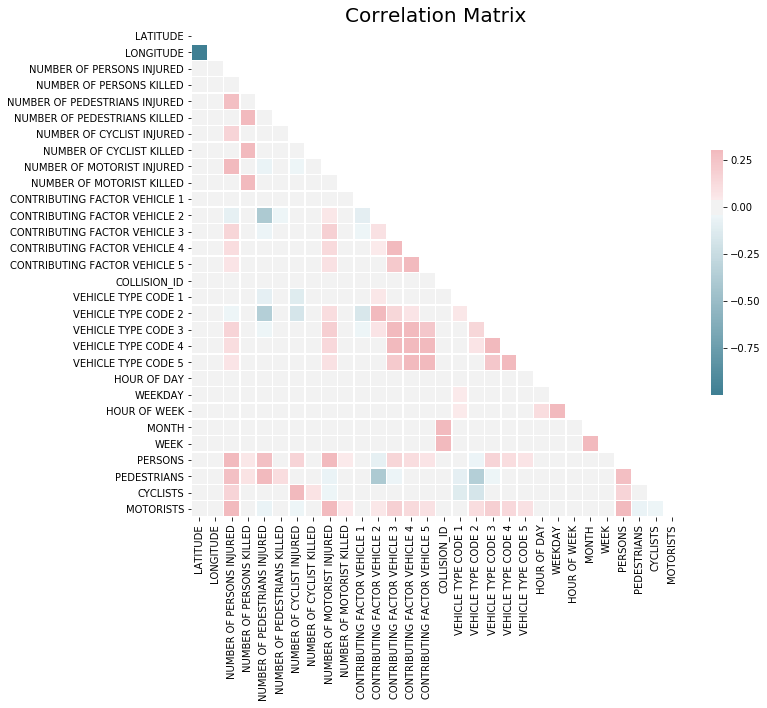

In [26]:
# Compute the correlation matrix
corr =time_series_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9));
plt.title('Correlation Matrix', fontsize=20)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## 3 Temporal Patterns

Something that could provide useful insight into causes behind the accidents is to look at temporal data. This data can be seen plotted in the graphs below. The temporal data used is hour of day, day in week, hour in week, month in year, and years. Except for the latter, these graphs will only include data for 2019. The number of deaths and injuries have been combined, since the trends being investigated are merely the temporal patterns, e.g. hours in the day, and trends between the different types of people involved in the accidents, e.g. pedestrians and motorists. The legend of the graphs can be clicked to select and deselect the type of persons involved to better explore the trends between them. 


In [ ]:
show(ps[0])

For all the types of people, it can be seen that crashes are most likely to occur during daytime around 8 am and from 2 pm till 6 pm than during nighttime, however a spike can be seen around midnight. The accidents during the aforementioned daytime hours could be due to rush hours where people are going to and from their job, school or the like. The spike at 12 pm could be related to driving under the influence or simply driver exhaustion leading to inattentive driving.


In [ ]:
show(ps[1])

Looking at accidents across the days in the week, it can be seen that most accidents occur during the week, friday generally having the highest number of accidents. This could support the interpretation for the previous graph regarding higher accident rates due to rush hours. Friday being the worst day could be related to the fact that it’s the day people can begin their weekend and therefore might be more likely to have plans after work that differ from plans during the other week days.  

In [ ]:
show(ps[2])

This graph shows similar patterns as were observed in the two previous graphs. Again, generally there are less accidents during the weekend, which is from hour 120 of the week till hour 168, however, the accident rate is higher during nighttime in the weekend than during the weekdays. This is likely caused by the fact that people are off work and are staying out till a later hour than during the weekdays. 


In [ ]:
show(ps[3])

For the months, looking at all types of people combined, there are more accidents from around May till October, and fewer for January and February, however an increase can be observed for December. An interesting observation can be made looking at the accidents for pedestrians and cyclists. The accident rate for pedestrians is more or less steady throughout the year, where the accident rate for cyclists is highest from Spring till Fall. A reason could be that people are more likely to use their bike when the weather is good. 


In [ ]:
show(ps[4])

For the final temporal pattern plot, the accident rates are seen for all years in the dataset, excluding 2012 and 2020, as data was not recorded for the whole of these years. It can be seen that the accident rate for motorists is rising from 2014-2019, while remaining steady for pedestrians and cyclists. However, as was seen earlier, the death rate for these has been rising during the later years. Regardless, the overall accident rate and death rate has not been declining since 2014, and it can again be concluded that the results of the implementation of Vision Zero cannot be seen.

The temporal patterns explored in this section indicated that the accident rate is higher during weekdays, especially Friday, and in the times of people going to and from work or school. Accidents during the nighttime in the weekend were higher than during nighttime in the week, and could be related to alcohol or simply the fact that people stay out later during the weekend than weekdays. Furthermore, accidents seem more likely to occur from spring till late fall, however with an increase for December. Less accidents are seen in January and February, the reason being unknown. It could be related to improved individual behavior and mentality at the start of a new year, but this is simply speculation. Another reason could be that the temperatures for these two months are the lowest for all months in the year [https://www.currentresults.com/Weather/New-York/Places/new-york-city-temperatures-by-month-average.php], however that could also result in more people choosing the car than walking, which looking at the contributing factors to accidents should in principle cause more accidents. Further investigations would have to be made to draw final conclusions, but the temporal patterns do provide an insight into the accident rates and its causes.


## 4 Exploring Geographical Patterns 


Exploring the geographical trends in the data is an important next step in order to perhaps find trends in accidents related to specific areas of the city, or streets. The data for the number of injured or killed was combined for each of the types of victims, namely pedestrians, cyclists, and motorists. 

In the map below, the geographical data for accidents where pedestrians were injured or killed in 2019 is plotted. It can be noticed that there is a concentration of accidents where pedestrians are involved in the Manhattan region, excluding the Central Park area which is seen as the area of no accidents in Manhattan. The Manhattan region of the city is the most densely populated region in New York City, and it doesn’t fall short of streets full with traffic and pedestrians [SOURCE]. Moving away from Manhattan, Queens, Bronx and Stataten Island have less density of accidents. However, they do have regions of more accidents. This could be due to fact that they are less densely packed, furthermore, since Manhattan has a larger amount of points of interest such as Times Square and Central Park, and the borough is quite significantly smaller in land area, it is natural to see these trends. 


In [ ]:
# drop nan location values because we want to plot them
df_heat = df.copy()
df_heat = df_heat.dropna(subset=['LATITUDE', 'LONGITUDE']).copy()

# create list of strings for each class to be used in loop in order to easily iterate through the classes and sample the data
classes = ['PEDESTRIANS', 'MOTORIST','CYCLIST']
# year of interest
year = '2019'
maps = []
# html code to include a title in the maps
titles = ['''<h3 align="center" style="font-size:20px"><b>Pedestrians Injured or Killed in NYC</b></h3>''',
          '''<h3 align="center" style="font-size:20px"><b>Motorists Injured or Killed in NYC</b></h3>''',
          '''<h3 align="center" style="font-size:20px"><b>Cyclists Injured or Killed in NYC</b></h3>''']

# loops through each of the classes in order to create a seperate map with different data
for i, victim in enumerate(classes):
    
    # necessary strings to identify columns in the dataset using specific class
    killed_text = 'NUMBER OF ' + victim + ' KILLED'
    injured_text = 'NUMBER OF ' + victim + ' INJURED'
    new_col_text = victim + ' INJURED/KILLED'
    
    # selecting desired data from df
    heat_df = df_heat[['CRASH DATE', 'LATITUDE','LONGITUDE', killed_text, injured_text]]
    # creating a new column including the combination of injured and killed victims
    heat_df[new_col_text] = heat_df[killed_text] + heat_df[injured_text]
    
    # replace missing values in new columns with nan to easily remove these datapoints
    heat_df[new_col_text] = heat_df[new_col_text].replace(0, np.nan)
    heat_df = heat_df.dropna(subset=[new_col_text])
    
    # selecting desired data from heat_df
    heat_df = heat_df[['CRASH DATE', 'LATITUDE','LONGITUDE',new_col_text]]
    
    # converting date column to datetime
    heat_df['CRASH DATE'] = pd.to_datetime(heat_df['CRASH DATE'])
    
    # cutting down data by selecting year of interest
    heat_df['YEAR'] = heat_df['CRASH DATE'].dt.year
    heat_df['YEAR'] = heat_df['YEAR'].astype(str)
    heat_df = heat_df[heat_df['YEAR']==year]
    
    # converting lat/long to float
    heat_df['LATITUDE'] = heat_df['LATITUDE'].astype(float)
    heat_df['LONGITUDE'] = heat_df['LONGITUDE'].astype(float)
    
    # we only want to plot lat/long
    heat_df = heat_df[['LATITUDE', 'LONGITUDE']]
    heat_df = [[row['LATITUDE'],row['LONGITUDE']] for index, row in heat_df.iterrows()]
    
    # Create heatmap
    Heat_map = folium.Map(location=[40.730610, -73.935242], zoom_start = 12) 
    
    HeatMap(heat_df, radius=10, max_zoom=10).add_to(Heat_map)

    title_html = titles[i]
    Heat_map.get_root().html.add_child(folium.Element(title_html))
    
    # append heatmap to list in order to plot it later
    maps.append(Heat_map)
    

In [ ]:
# Pedestrians Injured or Killed
maps[0]

<img src="https://drive.google.com/uc?id=188K2_nR7CyJ_SpRq1IF6c9BHozgH5RpW" alt="Image" height="300"/>

Looking at the pedestrian map, we thought it would be interesting to investigate areas that have a large concentration of casualties. After investigating several areas on google maps, it was noticed that these areas are busy pedestrian streets. Furthermore, it was noticed that the areas with more accidents occurring falled in intersections all around the city. An example of an intersection was selected that lies on the 7th Avenue. It is noticed that this is a shopping street where there are many restaurants and stores filled with people. The fact that there is a concentrated area of pedestrian related casualties is evident due to the large concentration of pedestrians and cars travelling in this street. But this trend is not limited to this crossroad, along 7th avenue there are many casualties. This could be due to this being a busy street with many pedestrians and motorists travelling.

There are a lot less cyclist related accidents recorded compared to pedestrians and motorists, but similar trends can be noticed compared to the previous. Manhattan is once again seen as an area where more casualties occur where cyclists get injured or killed, once again this could be due to this being the center of the city and a densely packed area.


In [ ]:
# Cyclists Injured or Killed
maps[2]

<img src="https://drive.google.com/uc?id=1WhpgrNfeMB3TDc1AWS8stm_yfIVuMYpl" alt="Image" height="300"/>

Perhaps by once again looking at some areas where there is a large concentration of cyclist related accidents, it will be possible to bring up some possible reasons for the cause of these accidents. An intersection was chosen from 5th Avenue as an example. Photos from Google Maps Street View were taken of this intersection. This looks to be a busy street with both pedestrians and cars. Furthermore, some cyclists are seen in this intersection where there are no bike lanes.. Noticing this, it is evident why these areas get a lot of cyclist accidents. And in general, if it is a common trend that there aren’t many bike lanes across the city, it could explain the reason behind cyclist related accidents, specially in intersections. 

There is a disproportionate amount of more data points related to injured or killed motorists in accidents. This is evident since this dataset relates motor vehicle crashes. In the heatmap below, all motirst related casualties in 2019 are plotted in order to see whether there are patterns in the distribution of accidents. Due to the larger amount of data points for this type, it is hard to see from this distance in the map what are the trends. However, by zooming in to Manhatten, and other areas of the city it was noticed that accidents are often occuring in intersections. When looking at a larger street such as 7th Avenue, this pattern is clearly seen for every intersection. Intersections are an occasion where it highly relies on attention, ability to yield, and regard to traffic lights in order to avoid colliding with cars coming from other directions. Relating back to the pie chart illustrating the contributing factors in pedestrian and cyclist casualties, it was seen that a large proportion was related to driver inattention or distraction, failure to yield, and disregard to traffic signs, this could have a connection to the amount of accidents that occur in intersections.



In [ ]:
maps[1]

Looking at the geographical data and the temporal data in conjunction could provide a new perspective of the data than what the two can provide on their own. In the following time-lapse, the temporal trends previously described can be seen for the different hours of the day. Comparing the number of accidents at 5 pm to those at 1 am, it is clear that the concentration of accidents differ greatly since 5 pm  lies in rush hour. Furthermore, it can be noticed that there are some areas in Manhattan and Brooklyn that are consistently showing large numbers of accidents throughout most hours of the day.


In [ ]:
# Create dataframe to use for bokeh plots, containing number of pedestrians, 
# cyclists, and motorists injured or killed in different time series
time_series_df = interval_data[['CRASH DATE', 'CRASH TIME','LATITUDE',
       'LONGITUDE','NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED']].copy()

# Create column to store hour of day
time_series_df['HOUR OF DAY'] = pd.to_datetime(time_series_df['CRASH TIME']).dt.hour.copy()

# Create column to store day of the week
time_series_df['WEEKDAY'] = pd.to_datetime(time_series_df['CRASH DATE']).dt.dayofweek.copy()

# Create column to store hour of the week
time_series_df['HOUR OF WEEK'] = time_series_df['WEEKDAY'] * 24 + time_series_df['HOUR OF DAY']

# Create column to store month 
time_series_df['MONTH'] = pd.to_datetime(time_series_df['CRASH DATE']).dt.month.copy()

#Create a column to store week
time_series_df['WEEK'] = pd.to_datetime(time_series_df['CRASH DATE']).dt.week.copy()

# Merge number of injured and dead for pedestrians, persons, cyclists, and motorists
time_series_df['PERSONS'] = time_series_df['NUMBER OF PERSONS INJURED'] + time_series_df['NUMBER OF PERSONS KILLED']
time_series_df['PEDESTRIANS'] = time_series_df['NUMBER OF PEDESTRIANS INJURED'] + time_series_df['NUMBER OF PEDESTRIANS KILLED']
time_series_df['CYCLISTS'] = time_series_df['NUMBER OF CYCLIST INJURED'] + time_series_df['NUMBER OF CYCLIST KILLED']
time_series_df['MOTORISTS'] = time_series_df['NUMBER OF MOTORIST INJURED'] + time_series_df['NUMBER OF MOTORIST KILLED']

# Drop not needed columns
time_series_df = time_series_df.drop(['NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED'], axis=1)

# Reset indices after drop
time_series_df.reset_index(drop=True, inplace = True)

# The PERSON column is of type float, change to integer
time_series_df['PERSONS'] = time_series_df['PERSONS'].astype(int)

# Only keep the rows where Latitude and Longitude values are present
time_series_df = time_series_df.dropna(subset=['LATITUDE'])
time_series_df = time_series_df.dropna(subset=['LONGITUDE'])

In [ ]:
def generateBaseMap(default_location=[40.730610, -73.935242], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [ ]:
#Generate time lapse for pedestrians injured/killed everty month
month_pedestrian_map = generateBaseMap()
title = '''<h3 align="center" style="font-size:20px"><b>Persons Injured or Killed in NYC every Hour of the Day in 2019</b></h3>'''

time_lapse_df = time_series_df[time_series_df.PERSONS > 0].copy()
time_lapse_df['Weight'] = time_lapse_df['HOUR OF DAY'].copy()
time_lapse_df['Weight'] = time_lapse_df['Weight'].astype(float)

# List comprehension to make out list of lists
time_lapse_df = [[[row['LATITUDE'],row['LONGITUDE']] for index, row in time_lapse_df[time_lapse_df['Weight']==i].iterrows()] for i in range(1,24)]

hm = plugins.HeatMapWithTime(time_lapse_df, auto_play=True, max_opacity=0.8)
hm.add_to(month_pedestrian_map)

month_pedestrian_map.get_root().html.add_child(folium.Element(title))
month_pedestrian_map

This further supports the observations made that the number of accidents relate to hour of the day and areas of the city. The observations made during this section will be the foundation for the following section, in which explanations for the observed patterns will be investigated.


## 5 POV from a Biker

A biker in New York City filmed their trip down Broome Street on a Friday in 2018 during a traffic jam (https://www.youtube.com/watch?v=0iKFgEPOk20). This 14 minutes long shot gives an impression of what it is like to be a bicyclist in the streets of New York. The video below shows a small part of the full video, but even from this small clip, several concerning factors can be observed.

<video controls src="https://drive.google.com/uc?id=1zYoNX-kcf7xWIMJ47kzH7cZ-XDzn505x" alt="Video" height="500" width="700" style="display:block; margin: 0 auto;" />

Some of the things that are immediately noticeable are the lack of bicycle lanes and high number of cars. The biker has to bike in and out between the cars, which can easily result in very dangerous situations. Looking at the video, traffic flow could be a determining factor for the number of accidents and casualties in the traffic. The following section will investigate the relationship between the traffic flow and traffic related accidents in NYC.


## 6 Traffic flow

Traffic Volume Count dataset provided by the city government of NYC [X] was used in order to investigate the traffic flow in relation to the number of accidents that occur. This dataset contains information about traffic volume count for specific dates, streets, and directions in NYC for years 2012 to the current date.
To compare the data from the two datasets, the data was grouped by hour. Below, the data for traffic flow and number of accidents per hour has been normalized to allow for comparison between the two types of data, as they are on a distinctively different scale. As can be seen, the two distributions looks strikingly similar.


In [ ]:
# Group accident_data by day and hour of day
times = pd.to_datetime(df['CRASH TIME'])
dates = pd.to_datetime(df['CRASH DATE'])
accident_group = df.groupby([dates,times.dt.hour]).size().copy()
accident_group = accident_group.to_frame('Accidents')

In [ ]:
# Retrieve "NY traffic volumn" data
url = 'https://data.cityofnewyork.us/api/views/ertz-hr4r/rows.csv?accessType=DOWNLOAD'
df_2 = pd.read_csv(url)


In [ ]:
# Convert date column to datetime
df_2['Date'] = pd.to_datetime(df_2['Date'])
df_2 = df_2.drop(['ID', 'Segment ID', 'Roadway Name', 'From', 'To', 'Direction'], axis=1)

In [ ]:
# Rename columns so that they match the ones in the Motor vehicle crash dataset
flow_group = df_2.copy()
flow_group = flow_group.rename(columns={'12:00-1:00 AM':0,'1:00-2:00AM':1,'2:00-3:00AM':2,'3:00-4:00AM':3,'4:00-5:00AM':4,'5:00-6:00AM':5,'6:00-7:00AM':6,'7:00-8:00AM':7,'8:00-9:00AM':8,'9:00-10:00AM':9,'10:00-11:00AM':10,'11:00-12:00PM':11})
flow_group = flow_group.rename(columns={'12:00-1:00PM':12,'1:00-2:00PM':13,'2:00-3:00PM':14,'3:00-4:00PM':15,'4:00-5:00PM':16,'5:00-6:00PM':17,'6:00-7:00PM':18,'7:00-8:00PM':19,'8:00-9:00PM':20,'9:00-10:00PM':21,'10:00-11:00PM':22,'11:00-12:00AM':23})

# Group flow_data by date and hour of day
flow_group = flow_group.groupby(flow_group['Date'].dt.date).sum().stack()
flow_group = flow_group.to_frame('Traffic_flow')

In [ ]:
#Concatenate the two series into a dataframe and drop NAN values
data_merge = pd.concat([flow_group, accident_group], axis=1).reset_index().rename_axis(None, axis=1)
data_merge = data_merge.dropna()
data_merge = data_merge.rename(columns={'level_0':'Date','level_1':'Hour'})

In [ ]:
#Group data by hour
data_plot = data_merge.groupby(data_merge['Hour']).sum()
data_plot['HOUR'] = data_plot.index
data_plot.rename(columns={'Traffic_flow':'Traffic Flow'}, inplace=True)

# Normalize traffic flow and accidents
data_plot['Traffic Flow'] = data_plot['Traffic Flow'] / np.max(data_plot['Traffic Flow'])
data_plot['Accidents'] = data_plot['Accidents'] / np.max(data_plot['Accidents'])

In [ ]:
# Create plot for traffic flow and accidents
p_tf_acc = create_plot('Traffic Flow and Number of Accidents per Hour', 'Hour', 'Normalized Count', ticks=list(range(0, 24)))

# Create custom color palette
tf_acc_custom = ['#515A5A', custom[0]]
tf_acc_custom_pal = sns.color_palette(tf_acc_custom)
tf_acc_custom_pal = tf_acc_custom_pal.as_hex()

# Convert data to bokeh ColumnDataSource
tf_acc_source = ColumnDataSource(data_plot)

# Types is used to loop through the source for the plots
types = ['Traffic Flow', 'Accidents']
bar = {}
items = [] 

# Create bar plots like before
for indx, i in enumerate(types):
    bar[i] = p_tf_acc.vbar(x='HOUR', 
                    muted_alpha=0.03, 
                    fill_alpha=0.7,  
                    line_color=(0,0,0,0.0), 
                    muted=False, 
                    width=0.6, 
                    top=i, 
                    color = tf_acc_custom_pal[indx],
                    muted_color = tf_acc_custom_pal[indx],
                    source=tf_acc_source)
    items.append((i, [bar[i]])) 

legend = Legend(items=items, location=(0,260)) 
p_tf_acc.add_layout(legend, 'left')
p_tf_acc.legend.click_policy="mute"
show(p_tf_acc)

This supports the observation made earlier regarding accidents being related to rush hours.
The plot above indicates that linear regression could be used to predict the number of traffic accidents based on traffic flow. Below, traffic volume count is plotted against the number of accidents.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

x = data_merge['Traffic_flow'].values.reshape(-1, 1)
y = data_merge['Accidents'].values

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/4, random_state = 0)
linearRegressor = LinearRegression()

linearRegressor.fit(xTrain, yTrain)
yPrediction = linearRegressor.predict(xTest)

# print("The score of the linear regression model is: {}".format(linearRegressor.score(xTest, yTest)))

In [ ]:
#Group data by hour
data_plot = data_merge.groupby(data_merge['Hour']).sum()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

x = data_plot['Traffic_flow'].values.reshape(-1, 1)
y = data_plot['Accidents'].values

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/4, random_state = 0)
linearRegressor = LinearRegression()

linearRegressor.fit(xTrain, yTrain)
yPrediction = linearRegressor.predict(xTest)

#print("The score of the linear regression model is: {}".format(linearRegressor.score(xTest, yTest))) 

In [ ]:
#Group data by hour
data_plot = data_merge.groupby(data_merge['Hour']).sum()
data_plot['HOUR'] = data_plot.index
data_plot.rename(columns={'Traffic_flow':'Traffic Flow'}, inplace=True)

In [ ]:
# Plot non-aggreated data. It does not look like that there is a linear trend
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(data_merge['Traffic_flow'], data_merge['Accidents'],c='lightblue',edgecolor='blue',alpha=0.8)
plt.title('Is there a linear relation?', fontsize=15)
plt.xlabel('Traffic Volume Count')
plt.ylabel('Traffic Accident Count')
plt.show()

Just looking at this plot, a relationship between traffic volume count and accident counts is not apparent. However, if the data is aggregated per hour, meaning that all data from e.g. 1-2 am is summed up across all days in the dataset,  the results indicate a positive correlation between the two. This can be seen in the plot below.


In [ ]:
# Plot the linear trend in the aggreated data
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(data_plot['Traffic Flow'], data_plot['Accidents'],c='lightblue',edgecolor='blue',alpha=0.8)
plt.title('Is there a linear relation?', fontsize=15)
plt.xlabel('Traffic Volume Count')
plt.ylabel('Traffic Accidents Count')
plt.show()

For the data behind both of these graphs, a linear regression model was used to predict the number of accidents based on traffic flow. The model built for the data without aggregating by hour got a R^2 score of 0.08. When aggregating the data by hour, a R^2 score of 0.95 was reached. This means that in the latter, the model accounts for a large percentage of the variance and the points fall close to the regression line which is the desired outcome when carrying out linear regression.

These results show that there is a positive correlation between traffic flow and number of accidents. Predicting the number of accidents based on traffic flow could provide an indication of how many accidents could be expected on a given day or time based on traffic flow data, and thus, necessary allocation of resources can be taken into consideration in order to help prevent as many accidents as possible. This furthermore indicates that a high traffic flow, e.g. during rush hour, is indeed one of the causes for the accidents,as was speculated when watching the video for the POV of a NYC biker. 


## 7 Predicting victim type 


Machine learning could be used to provide intuition on accidents that are yet to happen, and the areas where certain victims are more vulnerable than others. It could also offer the possibility of foreseeing whether certain areas are becoming more or less dangerous in relation to a specific victim type. Perhaps, a valuable tool to aid in the Vision Zero program of eliminating all traffic related deaths in NYC by 2024. 


### 7.1 Machine Learning

A K-nearest neighbour (KNN) classifier was created for the purpose of predicting, given the location of a victim, whether the victim was a pedestrian, a cyclist, or a motorist. Other machine learning models were also experimented with, such as Logistic Regression, Support Vector Machine, and Neural Networks. However none of these models produced results that outperformed the KNN model significantly. It was thought that a KNN would be the ideal model for this case since it classifies datapoints based on feature similarity, a often recommended value of K=3 was used for this model. For this purpose the accidents where there are multiple types of victims were excluded, thus simplifying the problem, and the size of the dataset. The accuracy of the model (60.12%) was arguably low when predicting the victim type for the latitude and longitude coordinates of a part of the dataset never before seen by the model. However, it is likely due to the fact that classifying such a precise location is likely to be very hard when there are so many datapoints that often use the same or similar coordinates. Perhaps by plotting the test data used, and the predictions will provide a better insight onto the performance of the model and whether the was in fact able to capture some of the trends. 


In [ ]:
# Functions to be used for machine learning
def replace(val):
    return 1 if val > 0 else 0

def multiple(row):
    return 1 if sum(row) > 1 else 0

def mu(row):
    if row['MULTIPLE'] == 1:
        row['PEDESTRIANS'] = 0
        row['CYCLISTS'] = 0
        row['MOTORISTS'] = 0
    return row

# Create functions for classification
def encodeOutput(y, hot_encode):
    # 0=PEDESTRIANS, 1='CYCLISTS', 2='MOTORISTS', 3='MULTIPLE'

    if hot_encode:
        # encode class values as integers
        encoder = LabelEncoder()
        encoder.fit(y)
        encoded_y = encoder.transform(y)
        # convert integers to dummy variables (i.e. one hot encoded)
        return np_utils.to_categorical(encoded_y)
    else:
        for i, col in enumerate(y.columns.tolist(), 0):
            y.loc[:, col] *= i
        return y.sum(axis=1)
    
def logistic(X_train, X_test, y_train, y_test):

    clf = LogisticRegression(C=1e5)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    accuracy_percentage = 100 * accuracy

    return y_pred, y_pred_prob, accuracy_percentage

def knn(X_train, X_test, y_train, y_test):
    
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    accuracy_percentage = 100 * accuracy
    
    return y_pred, y_pred_prob, accuracy

In [ ]:
# Create new dataframe for machine learning
ml_data = df.copy()

ml_data = ml_data[['CRASH DATE', 'CRASH TIME', 'LATITUDE', 'LONGITUDE',
             'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 
             'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 
             'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 
             'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED']]
year = 2019
ml_data = ml_data[ml_data['CRASH DATE'].dt.year == year]

ml_data = ml_data.rename(columns={'CRASH DATE':'DATE'})
#df_weather = df_weather.rename(columns={'date':'DATE'})

#df_weather = pd.merge(data, df_weather, how='inner')

# Create column to store hour of day
ml_data['HOUR OF DAY'] = pd.to_datetime(ml_data['CRASH TIME']).dt.hour.copy()
# Create column to store day of the week
ml_data['WEEKDAY'] = pd.to_datetime(ml_data['DATE']).dt.dayofweek.copy()
# Create column to store hour of the week
ml_data['HOUR OF WEEK'] = ml_data['WEEKDAY'] * 24 + ml_data['HOUR OF DAY']
# Create column to store month 
ml_data['MONTH'] = pd.to_datetime(ml_data['DATE']).dt.month.copy()

ml_data['PEDESTRIANS'] = ml_data['NUMBER OF PEDESTRIANS INJURED'] + ml_data['NUMBER OF PEDESTRIANS KILLED']
ml_data['CYCLISTS'] = ml_data['NUMBER OF CYCLIST INJURED'] + ml_data['NUMBER OF CYCLIST KILLED']
ml_data['MOTORISTS'] = ml_data['NUMBER OF MOTORIST INJURED'] + ml_data['NUMBER OF MOTORIST KILLED']
ml_data['TOTAL'] = ml_data['NUMBER OF PERSONS INJURED'] + ml_data['NUMBER OF PERSONS KILLED']

ml_data = ml_data[['LATITUDE', 'LONGITUDE', 'HOUR OF DAY', 'WEEKDAY', 'HOUR OF WEEK', 'MONTH', 'PEDESTRIANS', 'CYCLISTS', 'MOTORISTS']]

ml_data = ml_data.dropna()
        
ml_data['PEDESTRIANS'] = ml_data['PEDESTRIANS'].apply(replace)
ml_data['CYCLISTS'] = ml_data['CYCLISTS'].apply(replace)
ml_data['MOTORISTS'] = ml_data['MOTORISTS'].apply(replace)

ml_data_2 = ml_data[['PEDESTRIANS','CYCLISTS','MOTORISTS']].copy()

ml_data_2['MULTIPLE'] = ml_data_2.apply(multiple, axis=1)

ml_data_2 = ml_data_2.apply(mu, axis=1)

ml_data['PEDESTRIANS'] = ml_data_2['PEDESTRIANS']
ml_data['CYCLISTS'] = ml_data_2['CYCLISTS']
ml_data['MOTORISTS'] = ml_data_2['MOTORISTS']
ml_data['MULTIPLE'] = ml_data_2['MULTIPLE']

# removing values where they are all zeros
ml_data = ml_data[(ml_data[['PEDESTRIANS','CYCLISTS', 'MOTORISTS', 'MULTIPLE']] != 0).any(axis=1)]

In [ ]:
ped = ml_data[(ml_data[['PEDESTRIANS']] != 0).any(axis=1)].sample(n=4213,random_state=42)
cyc = ml_data[(ml_data[['CYCLISTS']] != 0).any(axis=1)].sample(n=4213,random_state=42)
mot = ml_data[(ml_data[['MOTORISTS']] != 0).any(axis=1)].sample(n=4213,random_state=42)

balanced = pd.concat([ped, cyc, mot])

balanced = balanced.sample(frac=1,random_state=4)

X = ml_data[['LATITUDE', 'LONGITUDE']].copy() #, 'HOUR OF WEEK', 'MONTH']].copy()
# X = ml_data[['LATITUDE', 'LONGITUDE', 'HOUR OF WEEK', 'MONTH']].copy()
y = ml_data[['PEDESTRIANS', 'CYCLISTS', 'MOTORISTS']].copy()

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

y = encodeOutput(y, hot_encode=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

classifier = 'KNN'

if classifier == 'KNN':
    preds, pred_prob, accuracy_percentage = knn(X_train, X_test, y_train, y_test)
    
elif classifier == 'LOGISTIC':
    preds, pred_prob, accuracy_percentage = logistic(X_train, X_test, y_train, y_test)

#print("Accuracy for " + classifier + ": " + str(np.round(accuracy_percentage*100,2)) + '%')

### 7.2 Plotting

The accidents for the three victim types motorists, cyclists, and pedestrians can be seen plotted on a map of NYC. Each dot represents an accident that occured in 2019 and in a color representing the different victim types (motorists: yellow, cyclists: green, and pedestrians: blue), which can be seen by clicking on a dot. 


In [ ]:
# Set NY coordinates
NY_coor = [40.730610, -73.935242]

In [ ]:
titles = ['''<h3 align="center" style="font-size:20px"><b>Accidents in NYC For all Victim Types</b></h3>''',
          '''<h3 align="center" style="font-size:20px"><b>Predicted Accidents in NYC For all Victim Types</b></h3>''']

# Create Folium map using NY coordinates
true_map = folium.Map(location=NY_coor, zoom_start = 10)

# Create pop ups for types in map
pop_ups = ['Pedestrian', 'Cyclist', 'Motorist']

for i in range(len(preds)):
    # Set location for map as longitude and latitud in X test
    loc_X = X_test.loc[i,'LONGITUDE']
    loc_Y = X_test.loc[i,'LATITUDE']
    
    # Use y_test value to color circle marker
    col = pal[1+y_test[i]],
    
    # Create marker as lat lon with color for X_test
    folium.Circle(location=[loc_Y, loc_X],
      popup=(pop_ups[preds[i]]),
      radius = 100,
      fill=True,
      fill_color=col,         
      color = col,
      opacity = 0.8, fill_opacity=0.8).add_to(true_map) 

# Add title
title_html = titles[0]
true_map.get_root().html.add_child(folium.Element(title_html))
    
# Show maps for y_test
true_map

Looking at the map, it can be seen that around the center of Manhattan, cyclists are more likely to be the victims of an accident, as many green dots are concentrated in this area. In Queens (south east of Manhattan) and Staten Island (south west of Manhattan), motorists are more likely to be victims of accidents. In Brooklyn (south of Manhattan), pedestrians are more likely to be the victims of an accident.
Using the location data from the data plotted above, the type of victim can be predicted and compared to the actual type of victim shown in the previous map. The predictions made by the KNN classifier described before are shown in the map below.


In [ ]:
# Create Folium map using NY coordinates
pred_map = folium.Map(location=NY_coor, zoom_start = 10)

# Create pop ups for types in map
pop_ups = ['Pedestrian', 'Cyclist', 'Motorist']

for i in range(len(preds)):
    # Set location for map as longitude and latitud in X test
    loc_X = X_test.loc[i,'LONGITUDE']
    loc_Y = X_test.loc[i,'LATITUDE']
    
    # Use preds to color circle marker
    col = pal[1+preds[i]],
    
    # Create marker as lat lon with color for X_test
    folium.Circle(location=[loc_Y, loc_X],
      popup=(pop_ups[preds[i]]),
      radius = 100,
      fill=True,
      fill_color=col,         
      color = col,
      opacity = 0.8, fill_opacity=0.8).add_to(pred_map) 
    
# Add title
title_html = titles[1]
pred_map.get_root().html.add_child(folium.Element(title_html))

# Show maps for predictions
pred_map

Comparing the two maps, the predictions do in fact seem to capture most of the trends observed in the actual data for the victim types, despite the KNN producing an accuracy around 60%. Unlike the map for the actual data, there is a higher concentration of predictions for pedestrians than bicyclists for central Manhattan, but there are still a number of predictions for bicyclists in the area. However, like for the actual data, the likelihood for pedestrians is high around Brooklyn, while for motorists the likelihood is high around Queens and Staten Island. The reason that the KNN is unable to accurately capture the true likelihoods for the victim types can be due to the fact that the dataset is highly unbalanced, the bicycle class being the one with the fewest observations, and the motorist class being the one with most. This could be solved by balancing the dataset, however balancing the dataset would be biased and would give an incorrect representation of reality, since for example motorists are to a much higher degree involved in accidents than pedestrians and bicyclists.

Predicting the most likely victim types for locations in NYC provided information about which areas are most dangerous to specific victims. This can be expanded by including time data, so as to be able to predict the victim type based on the hour of day, month etc. This would allow for making predictions for when and where accident types involving a specific victim type would occur, and ressources could be allocated accordingly. It proved to be difficult to accurately classify a victim type based on the accident’s latitude and longitude location. Perhaps by grouping the locations into districts or in a grid-like manner and classifying which victim type is more vulnerable in a given area would provide a model that performs better since it wouldn’t rely on an exact location, but instead, a group of locations that lie on the same area.


## 8 Discussion & Conclusion

This project set out to investigate the causes of the continuous increase in traffic accidents and deaths occurring in NYC in recent years despite the fact that Mayor Bill de Blasio in 2014 with his Vision Zero pledged to end traffic related deaths by 2024.  
Based on the analysis performed throughout, two main issues were identified. The first being that the infrastructure is likely to be a major contributing factor in the occurring accidents, a lack of bike lanes was seen, immense traffic flow and an indication that the infrastructure was not built to handle such traffic demand. Secondly, it was also seen that the major contributing factors responsible for deaths of pedestrians and cyclists in 2019 were related to careless motorist behaviour such as inattention or distraction, failure to yield, and a disregard to traffic lights. 

Proposals for solutions for the first of problems regarding infrastructure include altering the infrastructure of NYC by adding dedicated bike lanes. In fact, the city of New York has recently allocated $1.7 billion to changing road infrastructure over the next 10 years, including building more bus, pedestrian, and cyclist space, aspiring to improve safety for cyclists and pedestrians (https://www.theguardian.com/us-news/2019/nov/01/new-york-city-bike-lanes-car-culture). Based on the analysis conducted in this project, these implementation for the infrastructure could be a great step in the right direction to eliminate traffic related casualties. 

For the second problem, it seems necessary to making cars a less appealing choice of transportation. There has long been mention of charging NYC drivers to drive at busy hours in the city (https://www.businessinsider.com/nyc-drivers-may-have-to-pay-congestion-fee-in-2020-2018-1?r=US&IR=T), however this has yet to unfold. This could motivate more people to make use of other forms of transportation during rush hour and hereby lessen the traffic flow and  prevent accidents from happening during these times. Furthermore, to change the suboptimal behavior of the motorists, efforts could be made into combatting the contributing factors to pedestrian and cyclist deaths, as shown in the beginning of the analysis. Factors such as driver inattention, failure to yield etc. can be difficult to directly combat… However, factors such as alcohol and unsafe speed can be regulated with police effort in which more drivers are tested for substance abuse and more speed tickets are issued, or with more speed bumps, and traffic lights. The latter two rely on changes in the infrastructure, indicating that perhaps these infrastructure and suboptimal driver behavior are related and measures taken in one can improve the other.

Implementing these suggestions could help realize the vision of Mayor Bill de Blasio and definitively end all traffic related casualties. 
